Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
    8192/11490434 [..............................] - ETA: 0s

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
{'BATCH_SIZE': <hyperopt.pyll.base.Apply object at 0x7f0ece568c50>, 'dropout_rate': <hyperopt.pyll.base.Apply object at 0x7f0ece568e48>, 'lr_initial_g': <hyperopt.pyll.base.Apply object at 0x7f0ece5980b8>}
{'BATCH_SIZE': 128, 'dropout_rate': 0.8714440730715539, 'lr_initial_g': 0.0037854854458737198, 'lr_initial_d': 0.0037854854458737198}
  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

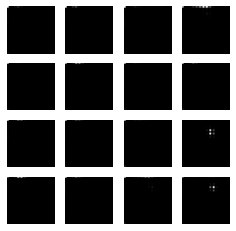

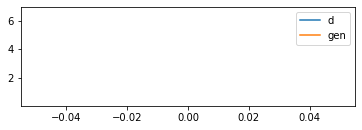

new_best_model
Time for epoch 1 is 37.15104365348816 sec
GEN:True DISCTrue
GEN:6.644875 DISC0.34506083
  0%|          | 0/20 [00:37<?, ?it/s, best loss: ?]

In [0]:
#@title Default title text
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf

tf.__version__

# To generate GIFs
!pip install imageio
import os
import csv
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from hyperopt import STATUS_OK
from hyperopt import tpe, hp, Trials, fmin
from IPython import display
from matplotlib import pyplot
from hyperopt import STATUS_OK
from hyperopt import tpe, hp, Trials, fmin
from keras import backend as K


with open('Original dataset/TrainOneCls.csv', 'r') as file:
      data = {"Xtrain": pd.DataFrame(list(csv.DictReader(file))).astype(float), "class": 2}
      data["Classification"] = data["Xtrain"]['Classification']
      del data["Xtrain"]['Classification']

f_myfile = open('Test_LR/Pickle/train_10x10_MI.pickle', 'rb')
data["img"] = pickle.load(f_myfile)
f_myfile.close()

a=np.where(data["Classification"]==0)

train_images=np.array([data["img"][index] for index in a[0]])
print(len(train_images))
train_images = train_images.reshape(train_images.shape[0], 10, 10, 1).astype('float32')

BUFFER_SIZE = 60000
BATCH_SIZE = 0
optimizable_variable = {"BATCH_SIZE": hp.choice("BATCH_SIZE", [64,128,256]),
                        'dropout_rate': hp.uniform("dropout_rate", 0, 1),  #Best PARAM = 0.3
                        'lr_initial_g': hp.uniform("lr_initial_g", 1e-2, 1e-4),   # 1e-4
                        #'lr_initial_d': hp.uniform("lr_initial_d", 1e-2, 1e-4)   # 1e-4
                        #"lr_initial_d": hp.uniform("lr_initial_d", 0.001, 0.0001)    # 1e-4
                        }
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
#dropout_rate=0.3

# Batch and shuffle the data
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def make_generator_model(dropout_rate):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model


def make_discriminator_model(dropout_rate):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))

    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss/2

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def train_step(images,train_d,train_g,generator,discriminator,generator_optimizer,discriminator_optimizer):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    if train_d:
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    if train_g:
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, disc_loss

def plot_history(d_hist, g_hist, step=0, is_global=False):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(d_hist, label='d')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    pyplot.show()

total_step=0

def opt(param):
  global BATCH_SIZE
  BATCH_SIZE=param["BATCH_SIZE"]
  train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(param["BATCH_SIZE"])
  generator = make_generator_model(param["dropout_rate"])

  noise = tf.random.normal([1, 100])
  discriminator = make_discriminator_model(param["dropout_rate"])


  generator_optimizer = tf.keras.optimizers.Adam(param["lr_initial_g"])
  param["lr_initial_d"]=param["lr_initial_g"]
  discriminator_optimizer = tf.keras.optimizers.Adam(param["lr_initial_d"])


  loss,generator,discriminator=train(train_dataset, EPOCHS,generator,discriminator,generator_optimizer,discriminator_optimizer,param)
  
  noise = tf.random.normal([1024, 100])
  predictions = generator(noise, training=False)
  fig = plt.figure(figsize=(5,5))
  global total_step
  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig("/content/drive/My Drive/gan mnist/results_no_error/img_"+str(total_step)+".png")
  plt.show()
  #sottrazione media
  errors =  - predictions
  scalar_error=np.mean(np.mean(np.power(train_images[0:1024] - predictions, 2), axis=1))
  print(scalar_error)
  K.clear_session()
  global res_error
  res_error.append(param)
  res_error[-1]["error"]=scalar_error
  with open("/content/drive/My Drive/gan mnist/results_no_error/resError.csv", 'w', newline='') as csvfile:
          writer = csv.DictWriter(csvfile, fieldnames=res[0].keys())
          writer.writeheader()
          writer.writerows(res)
  return {'loss': loss, 'status': STATUS_OK}


  
res=[]
res_error=[]
def train(dataset, epochs,generator,discriminator,generator_optimizer,discriminator_optimizer,param):
  print(param)
  global res
  global total_step
  res.append(param)
  total_step=total_step+1
  gen_ls=[]
  disc_ls=[]
  train_g=True
  train_d=True
  loss1=[]
  for epoch in range(epochs):
    start = time.time()
    gen=[]
    disc=[]
    for image_batch in dataset:
      gen_loss, disc_loss= train_step(image_batch,train_d,train_g,generator,discriminator,generator_optimizer,discriminator_optimizer)
      disc.append(disc_loss)
      gen.append(gen_loss)

    gen_ls.append(np.mean(gen))
    disc_ls.append(np.mean(disc))
    loss1.append(np.mean(gen)+np.mean(disc))
    
    with open("/content/drive/My Drive/gan mnist/results_no_error/res.csv", 'w', newline='') as csvfile:
          writer = csv.DictWriter(csvfile, fieldnames=res[0].keys())
          writer.writeheader()
          writer.writerows(res)
    # Produce images for the GIF as we go
    #display.clear_output(wait=True)

    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    plot_history(disc_ls,gen_ls)


    if loss1[-1]==min(loss1):
      print("new_best_model")
      res[-1].update({"gen":gen_ls[-1],"disc":disc_ls[-1]})

      generator.save_weights("gen_"+str(total_step)+"_"+str(epoch)+".h5")
      discriminator.save_weights("disc_"+str(total_step)+"_"+str(epoch)+".h5")
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print("GEN:"+str(train_g)+" DISC"+str(train_d))
    print("GEN:"+str( gen_ls[-1])+" DISC"+str( disc_ls[-1]))

  # load best model
  generator.load_weights("gen_"+str(total_step)+"_"+str(np.argmin(loss1))+".h5")
  discriminator.load_weights("disc_"+str(total_step)+"_"+str(np.argmin(loss1))+".h5")
  #result folder
  generator.save_weights("/content/drive/My Drive/gan mnist/results_no_error/gen_"+str(total_step)+"_"+str(epoch)+".h5")
  discriminator.save_weights("/content/drive/My Drive/gan mnist/results_no_error/disc_"+str(total_step)+"_"+str(epoch)+".h5")
  
   
  return min(loss1),generator,discriminator

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)






seed = tf.random.normal([num_examples_to_generate, noise_dim])
trials= Trials()
print(optimizable_variable)
newpath = r'results' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
fmin(opt, optimizable_variable, algo=tpe.suggest, max_evals=20)


#train(train_dataset, EPOCHS)

"""Restore the latest checkpoint."""

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

"""## Create a GIF"""

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

"""Use `imageio` to create an animated gif using the images saved during training."""

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

"""If you're working in Colab you can download the animation with the code below:"""

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

"""## Next steps

This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
"""